In [1]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import sys
import numpy as np
import json
import time
import os
# User imports
from Misc import read_binary

In [2]:
def get_run_logdir(root_logdir):
    import time
    run_id = time.strftime("run__%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [3]:
os.chdir("../../../../../")
root = "data/full/"
train_root_path = f"{root}/prepared/train"
reference_data_root = f"data/full/data_bcgw/"
raw_data_root = f"{root}data_img/"

In [4]:

# Prepare Folders
target_all = {
    "conifer" : "CONIFER.bin",
    "ccut" : "CCUTBL.bin",
    "water": "WATER.bin",
    "broadleaf" : "BROADLEAF.bin",
    "shrub" : "SHRUB.bin",
    "mixed" : "MIXED.bin",
    "herb" : "HERB.bin",
    "exposed" : "EXPOSED.bin",
    "river" : "Rivers.bin",
    # "road" : "ROADS.bin",
    # "vri" : "vri_s3_objid2.tif_proj.bin",
}
classes = ["unlabelled"]

keys = list(target_all.keys())
for key in keys:
    classes.append(key)





In [5]:
outdir = os.path.join(os.curdir,'outs')
if not os.path.exists(outdir):
    os.mkdir(outdir)
outdir = os.path.join(outdir, 'RandomForestBinary')
if not os.path.exists(outdir):
    os.mkdir(outdir)
outdir = os.path.join(outdir, 'KFold')
if not os.path.exists(outdir):
    os.mkdir(outdir)
outdir = get_run_logdir(outdir)
os.mkdir(outdir)

In [6]:
X = np.load(f'{train_root_path}/full-img.npy')

In [7]:
sub_img_shape = (4835//5,3402)
fold_length = sub_img_shape[0] * sub_img_shape[1]

In [8]:
n_est = 250

In [9]:
for target in target_all.keys():
        reference_path = f'{reference_data_root}{target_all[target]}'
        if os.path.exists(reference_path):
            cols, rows, bands, y = read_binary(reference_path, to_string=False)
            # encode the values to 0/1
            ones = np.ones((cols * rows))
            vals = np.sort(np.unique(y))
            # create an array populate with the false value
            t = ones * vals[len(vals) - 1]
            if target == 'water':
                y = np.not_equal(y, t)
            else:
                y = np.logical_and(y, t)

            """----------------------------------------------------------------------------------------------------------------------------
            * KFold Training
            """
            for test_idx in range(5):
                print(test_idx)
                path = os.path.join(outdir, f"fold_{test_idx}")
                if not os.path.exists(path):
                    os.mkdir(path)

                params = {
                        'n_estimators': n_est,
                        'max_depth': 6,
                        'max_features': 0.2,
                        'verbose': 0,
                        'n_jobs': -1,
                        # 'bootstrap': False,
                        'oob_score': True,
                        'warm_start': True
                    }
                clf = RandomForestClassifier(**params,)

                processing_time = {'fit': [], 'predict': []}

                X_test = X[test_idx * fold_length : (test_idx + 1)*fold_length, :]
                y_test = y[test_idx * fold_length : (test_idx + 1)*fold_length]

                for train_idx in range(5):
                    if train_idx == test_idx:
                        continue
                    X_train = X[train_idx * fold_length : (train_idx + 1)*fold_length, :]
                    y_train = y[train_idx * fold_length : (train_idx + 1)*fold_length]
                    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9)
                    print("Train IDX ", train_idx)
                    start_fit = time.time()
                    clf.fit(X_train, y_train)
                    clf.n_estimators = clf.n_estimators + n_est
                    end_fit = time.time()
                    fit_time = round(end_fit - start_fit, 2)
                    processing_time['fit'].append(fit_time)

                test_pred_confidence = clf.predict_proba(X_test)
                np.save(f'{path}/{target}', test_pred_confidence[:,1])
                test_pred_class = clf.predict(X_test)
                f, ax = plt.subplots(2,1, sharey=True, figsize=(30,15))
                f.suptitle(f"{target} Test Reference vs Prediction")
                colormap_y = ax[0].imshow(y_test.reshape(sub_img_shape) , cmap='gray', vmin=0, vmax=1)
                ax[0].set_title('Ground Reference')
                ax[1].imshow(test_pred_confidence[:,1].reshape(sub_img_shape), cmap='gray', vmin=0, vmax=1)
                ax[1].set_title('Prediction Confidence')

                plt.savefig(f'{path}/{target}_test_predvsref')
                plt.close()
                score = str(accuracy_score(y_test, test_pred_class))
                bal_score = str(balanced_accuracy_score(y_test, test_pred_class))
                print(test_idx)
                print(score)
                print(bal_score)
                with open(path + f"/{target}_results.txt", "w") as f:
                     f.write("Accuracy Test: " + score )
                     f.write("\nBalanace Accuracy Test: " + bal_score)
                    # f.write("\nScore Train: " +str(score_train))
                    # f.write("\nMSE Test: " + str(mse_test))
                    # f.write("\nMSE Train: " + str(mse_train))
                    # f.write("\nProcessing Times:")
                    # f.write(json.dumps(processing_time, indent=4, separators=(',', ': ')))
                    # f.write("\nOob Score: " + str(clf.oob_score_))
                    # f.write("\nFeature Importance: " + str(clf.feature_importances_))


	samples 3402 lines 4835 bands 1
+r data/full/data_bcgw/CONIFER.bin
0
Train IDX  1
Train IDX  2
Train IDX  3
Train IDX  4
0
0.898115470734108
0.7551898053447201
1
Train IDX  0
Train IDX  2
Train IDX  3
Train IDX  4
1
0.8999292951952954
0.8293814470834574
2
Train IDX  0
Train IDX  1
Train IDX  3
Train IDX  4
2
0.8958487221155267
0.7310172776627467
3
Train IDX  0
Train IDX  1
Train IDX  2
Train IDX  4
3
0.8750968923323283
0.6855741678311186
4
Train IDX  0
Train IDX  1
Train IDX  2
Train IDX  3
4
0.8651784612372915
0.6468654011581055
	samples 3402 lines 4835 bands 1
+r data/full/data_bcgw/CCUTBL.bin
0
Train IDX  1
Train IDX  2
Train IDX  3
Train IDX  4
0
0.8547052740434333
0.8571161919269623
1
Train IDX  0
Train IDX  2
Train IDX  3
Train IDX  4
1
0.8249581881088258
0.8247955267493895
2
Train IDX  0
Train IDX  1
Train IDX  3
Train IDX  4
2
0.8470335291546368
0.8466938558760275
3
Train IDX  0
Train IDX  1
Train IDX  2
Train IDX  4
3
0.8265498061545401
0.829857733321539
4
Train IDX  0
Train 

In [10]:
import pandas as pd

In [11]:
dfs = list()


for idx in range(5):
    df = pd.DataFrame(columns= target_all.keys())
    path = os.path.join(outdir, f"fold_{idx}")
    for idx, target in enumerate(target_all.keys()):
        df[target] = np.load(f'{path}/{target}.npy')
    np_df = df.to_numpy()
    np_df = np.argmax(np_df, axis=1)
    np_df = np_df + 1

    dfs.append(np_df)

In [12]:
def imshow_with_colorbar(y, filename, img_shape, classes, title="Image"):
    plt.title(title)
    plt.figure(figsize = (30,15))  
    colormap = plt.imshow(y.reshape(img_shape), cmap='cubehelix', vmin=0, vmax=len(classes))
    cbar = plt.colorbar(colormap,
                    orientation='vertical',
                    boundaries=range(len(classes) + 1), shrink=.95,extend='max', extendrect=True, drawedges=True, spacing='uniform')
    cbar.ax.set_yticklabels(classes)
    plt.savefig(f'{filename}')
    print(f'+w {filename}')
    plt.show()
#     plt.close()

(array([1, 2, 3]), array([2769936,  352612,  167186]))
+w ./outs/RandomForestBinary/KFold/run__2020_06_22-16_04_31/0_confidence_map


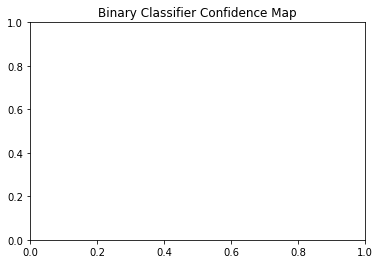

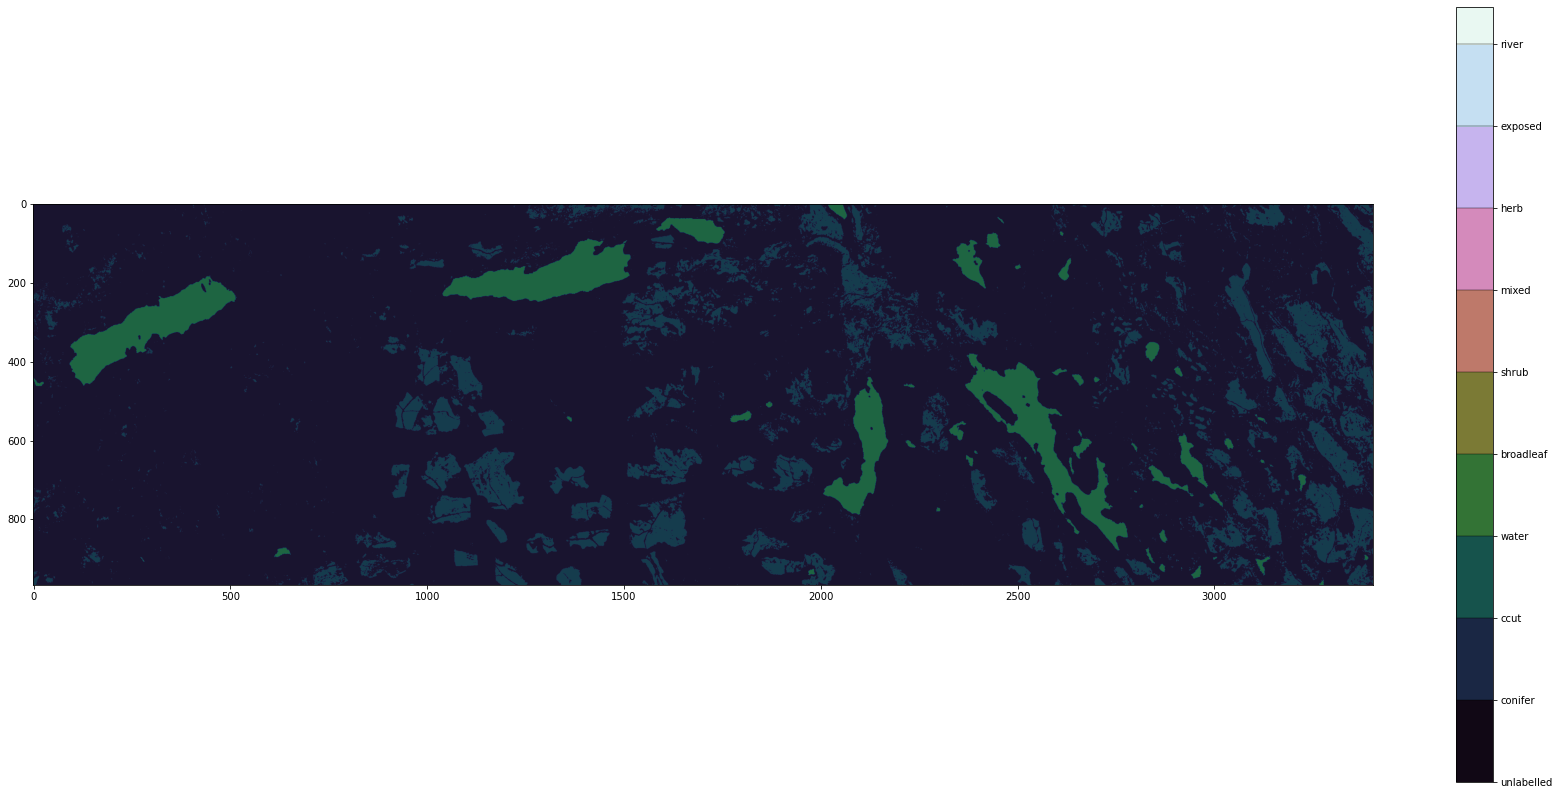

(array([1, 2, 3]), array([2488530,  419648,  381556]))
+w ./outs/RandomForestBinary/KFold/run__2020_06_22-16_04_31/1_confidence_map


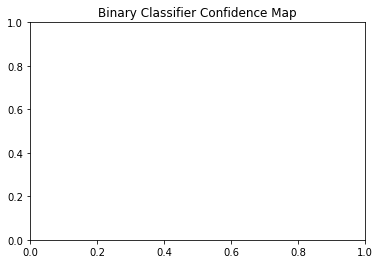

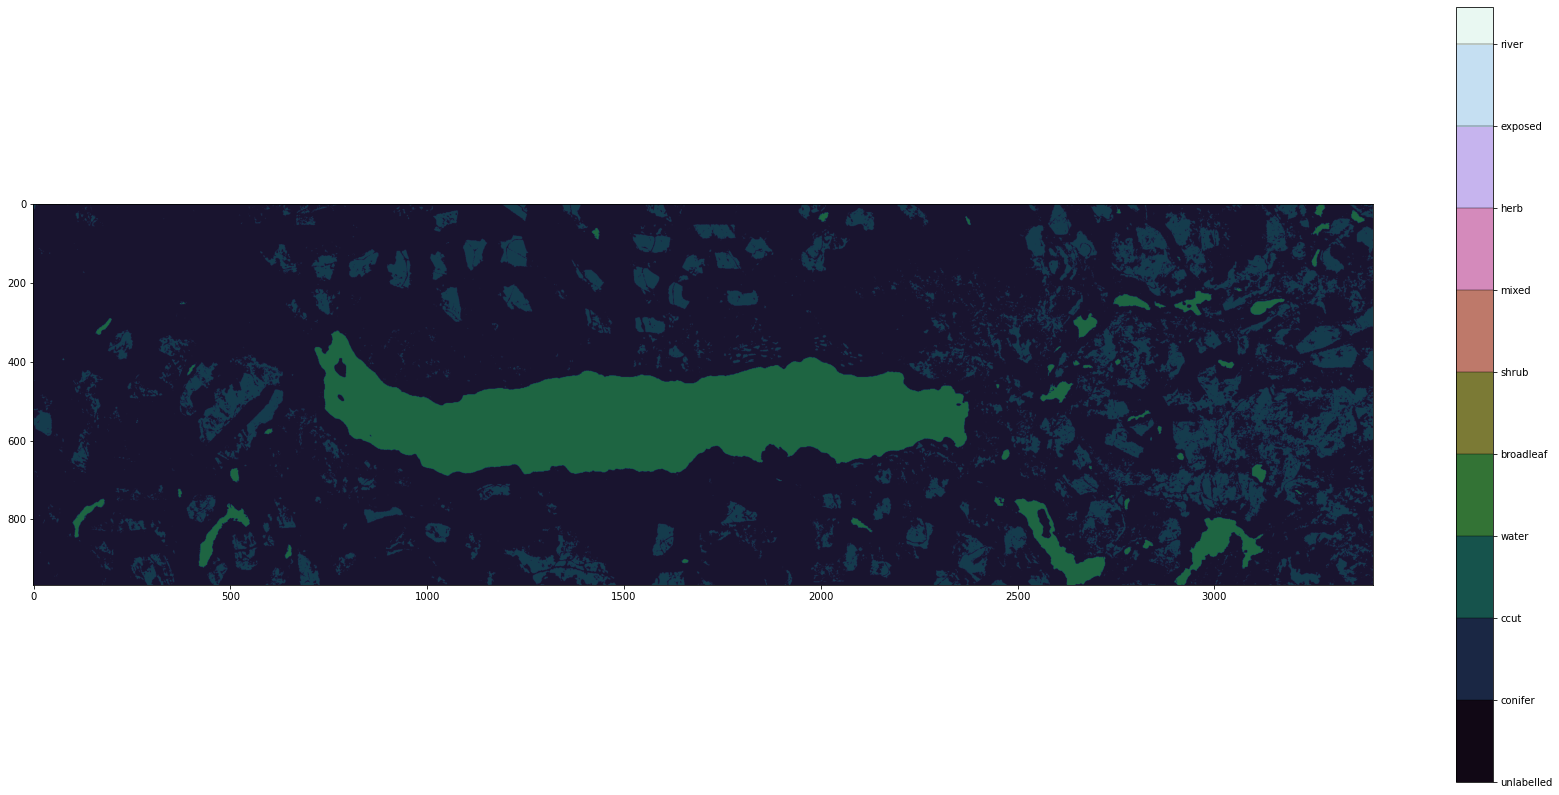

(array([1, 2, 3]), array([2795080,  389806,  104848]))
+w ./outs/RandomForestBinary/KFold/run__2020_06_22-16_04_31/2_confidence_map


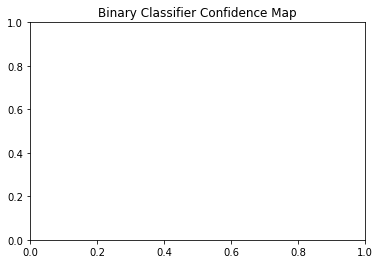

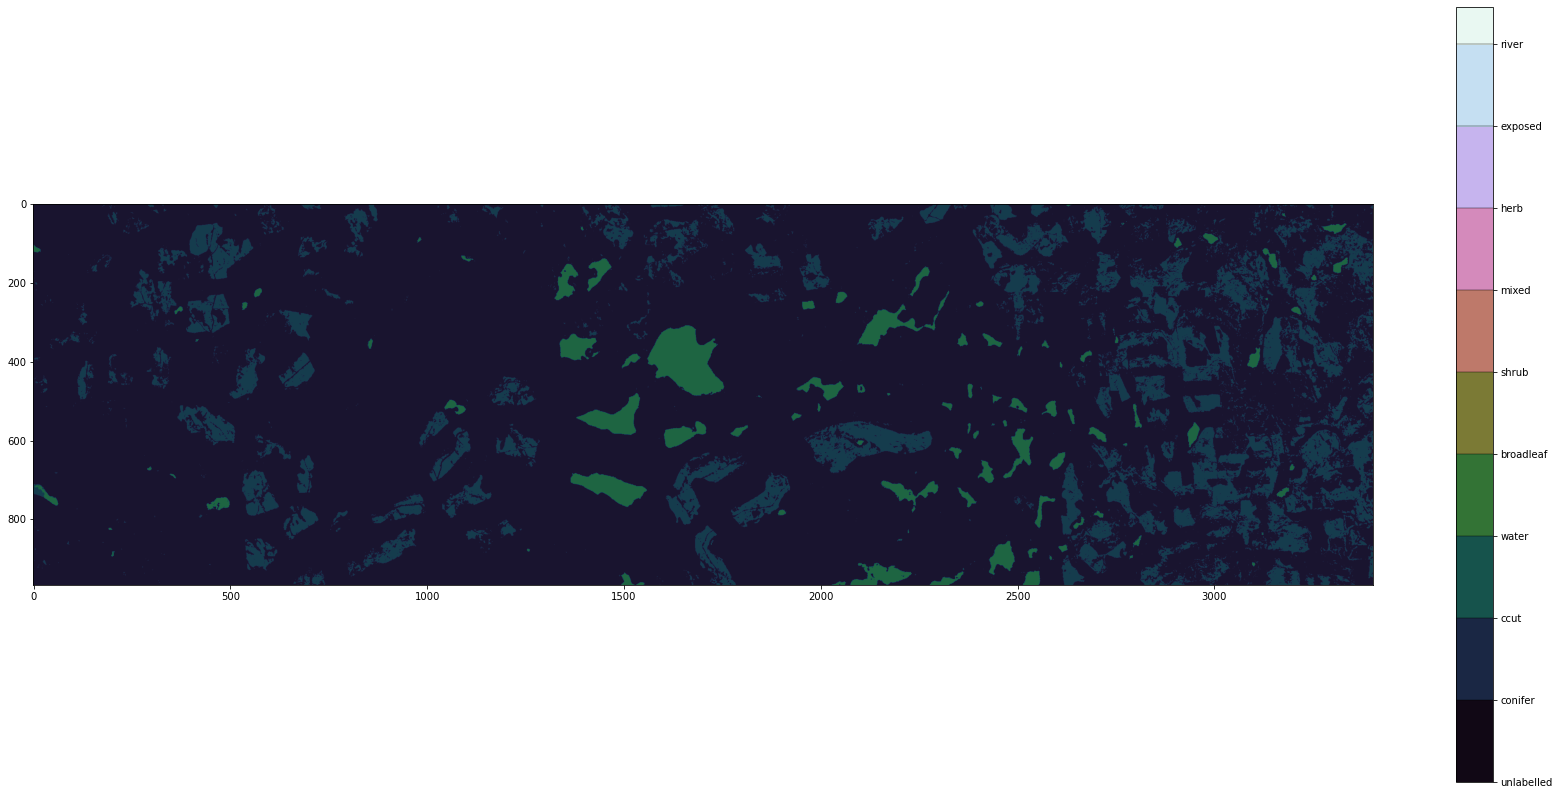

(array([1, 2, 3]), array([2793770,  461409,   34555]))
+w ./outs/RandomForestBinary/KFold/run__2020_06_22-16_04_31/3_confidence_map


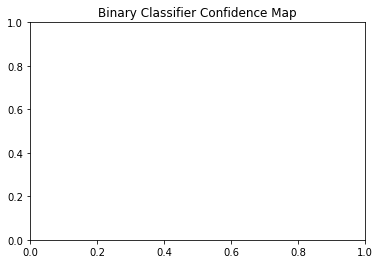

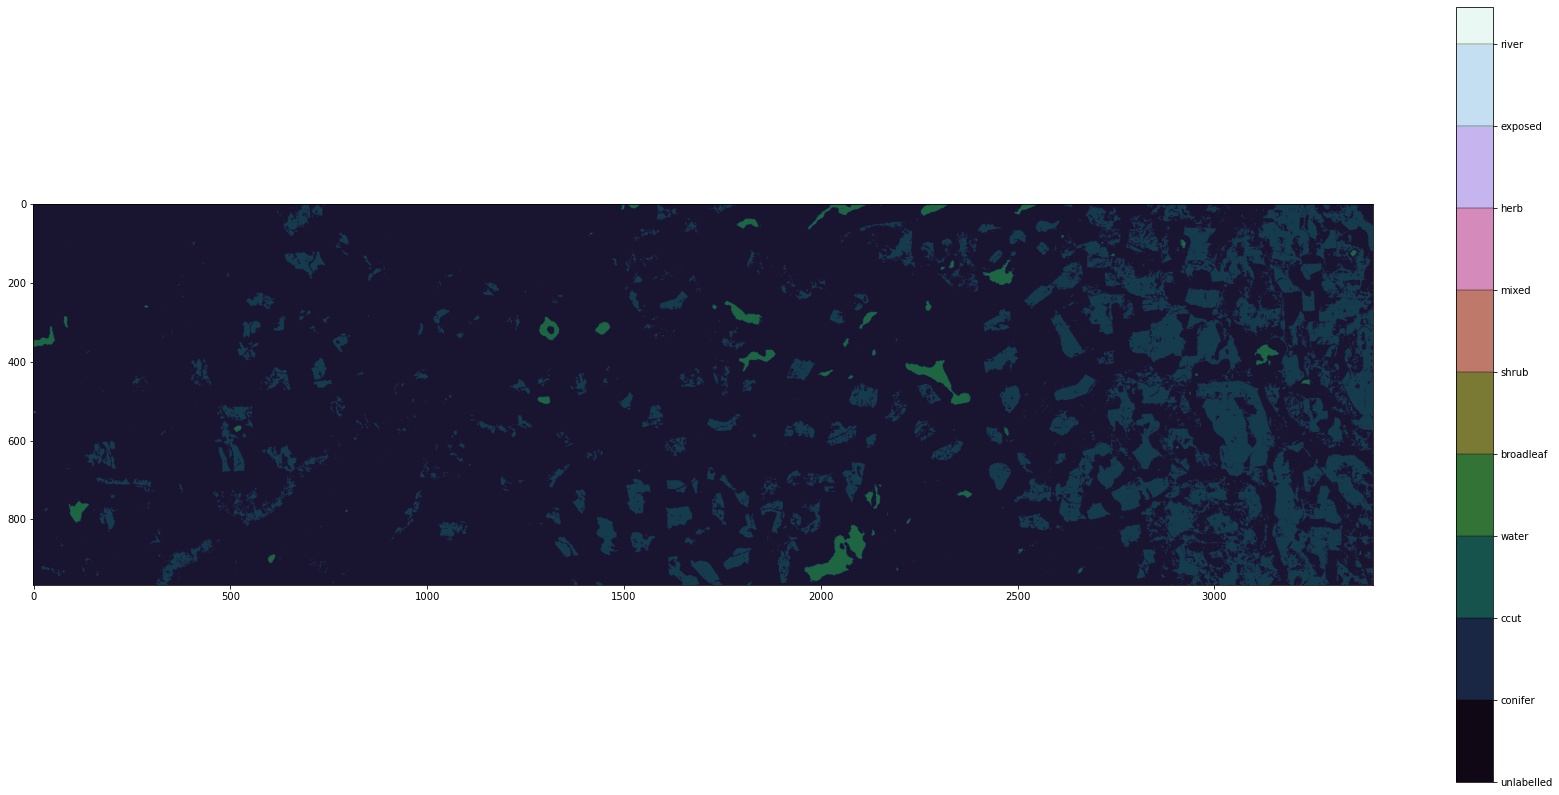

(array([1, 2, 3]), array([2799348,  486636,    3750]))
+w ./outs/RandomForestBinary/KFold/run__2020_06_22-16_04_31/4_confidence_map


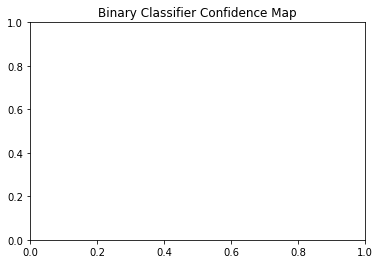

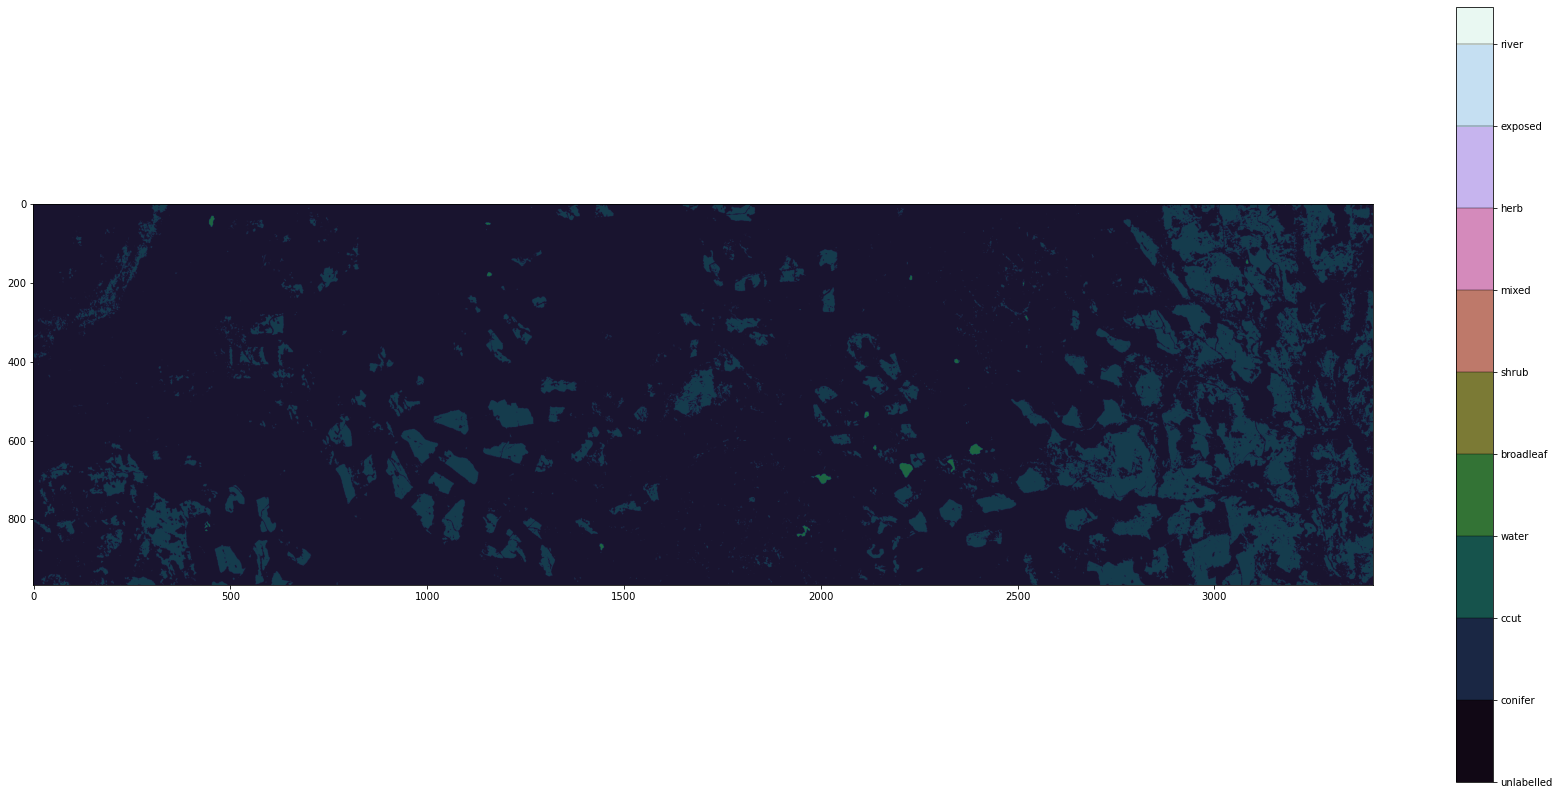

In [13]:
for idx, np_df in enumerate(dfs):
    print(np.unique(np_df, return_counts=True))
    imshow_with_colorbar(np_df,f'{outdir}/{idx}_confidence_map', sub_img_shape, classes, title="Binary Classifier Confidence Map" )
#     plt.title("Binary Classifier Confidence Map")
#     plt.figure(figsize = (30,15))
#     colormap = plt.imshow(np_df.reshape(sub_img_shape), cmap='cubehelix', vmin=0, vmax=10)
    
#     cbar = plt.colorbar(colormap,
#                   orientation='vertical',
#                  boundaries=range(11), shrink= .95,extend='max', extendrect=True, drawedges=True, spacing='uniform')
#     cbar.ax.set_yticklabels(["unlabelled",
#         "conifer",
#         "ccut",
#         "water",
#         "broadleaf",
#         "shrub",
#         "mixed",
#         "herb",
#         "exposed",
#         "river",""])
#     plt.savefig(f'{outdir}/{idx}_confidence_map')
#     plt.show()